### 1. Initialization
$ V(s) \in \mathbb{R} $ and $ \pi(s) \in A(s) $ arbitrarily for all $ s \in S $; $ V(\text{terminal}) = 0 $

### 2. Policy Evaluation
```python
Loop:
    Δ ← 0
    Loop for each s ∈ S:
        v ← V(s)
        V(s) ← Σ_{s',r} p(s',r|s,π(s)) [r + γ V(s')]
        Δ ← max(Δ, |v - V(s)|)
until Δ < θ (a small positive number determining the accuracy of estimation)
```

### 3. Policy Improvement
```python
policy-stable ← true
For each s ∈ S:
    old-action ← π(s)
    π(s) ← argmax_a Σ_{s',r} p(s',r|s,a) [r + γ V(s')]
    if old-action ≠ π(s), then policy-stable ← false
if policy-stable, then stop and return V ≈ v_* and π ≈ π_*; else go to 2
```

In [1]:
# Plotting funcs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [1]:
def plot_policy(policy):
    plt.imshow(policy[:, :], origin="lower")
    plt.colorbar()
    ax = plt.gca()
    # Rewrite the y labels
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f"))

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f"))

    # add the value of each pixel as a text annotation
    for (j, i), label in np.ndenumerate(policy):
        # if the value is more than -1, use a black font. Otherwise, use white
        # ax.text(i, j, label, ha="center", va="center")
        if label > -2:
            ax.text(i, j, label, ha="center", va="center", color="black")
        else:
            ax.text(i, j, label, ha="center", va="center", color="white")
    plt.show()


def plot_value_function(V):
    fig = plt.figure()

    # Specify that we are going to create a 3D plot
    ax = fig.add_subplot(111, projection="3d")

    x = np.linspace(0, 1, 21)
    y = np.linspace(0, 1, 21)
    X, Y = np.meshgrid(x, y)

    # Plot the surface
    ax.plot_surface(X * 20, Y * 20, V)

    # Show the plot
    plt.show()

In [2]:
def initialise():
    loc1_capacity = 20
    loc2_capacity = 20
    max_moves = 5

    V = np.random.random(size=(loc1_capacity + 1, loc2_capacity + 1))

    # the action space is moving cars between loc1 and loc2. There are 3 cases:
    # +ve: n cars moved from 1 -> 2
    # 0  : no cars moved
    # -ve: n cars moved from 2 -> 1
    A = np.arange(-max_moves, max_moves + 1)
    pi = np.zeros_like(V, dtype=int)
    pi += 5

    return V, A, pi


V, A, pi = initialise()

NameError: name 'np' is not defined

In [3]:
from scipy.stats import poisson

gamma = 0.9


def create_probability_array():
    req_1_dist = np.array([poisson.pmf(k=k, mu=3) for k in range(0, 21)])
    req_2_dist = np.array([poisson.pmf(k=k, mu=4) for k in range(0, 21)])
    ret_1_dist = np.array([poisson.pmf(k=k, mu=3) for k in range(0, 21)])
    ret_2_dist = np.array([poisson.pmf(k=k, mu=2) for k in range(0, 21)])

    arr1_exp = req_1_dist[:, np.newaxis, np.newaxis, np.newaxis]
    arr2_exp = req_2_dist[np.newaxis, :, np.newaxis, np.newaxis]
    arr3_exp = ret_1_dist[np.newaxis, np.newaxis, :, np.newaxis]
    arr4_exp = ret_2_dist[np.newaxis, np.newaxis, np.newaxis, :]

    # Precompute array of all combinations using broadcasting - will make the output much faster
    probs_array = arr1_exp * arr2_exp * arr3_exp * arr4_exp
    return probs_array


probs_array = create_probability_array()


def move_cars(s: tuple[int, int], a: int, verbose=False) -> tuple[int, tuple[int, int]]:
    n1, n2 = s
    if verbose:
        print(f"Starting State: {s}")

    # first we move the cars
    n_moved = A[a]
    if verbose:
        print(f"Moving {n_moved} car(s)")

    # $2 cost per car moved
    r_moving = -abs(n_moved) * 2

    # execute the move
    n1 -= n_moved
    n2 += n_moved

    # if either value is negative the model has taken an impossible action:
    # just return to prev state
    if (n1 < 0) or (n2 < 0):
        if verbose:
            print(f"Invalid action {n_moved=} from state {s=}")
        return 0, s, False

    # at most we can have 20 cars at a location
    n1 = min(n1, 20)
    n2 = min(n2, 20)

    if verbose:
        print(f"Post-move: {n1=} {n2=}")

    new_state = (n1, n2)
    return r_moving, new_state, True


explo_dim = 15


def new_state_value(s: tuple[int, int], V: np.ndarray, r_move: int):
    expected_reward = 0
    proba_sum = 0
    for hires1, hires2, returns1, returns2 in np.ndindex(
        (explo_dim, explo_dim, explo_dim, explo_dim)
    ):
        n1, n2, r1, r2, proba = cached_value_func(s, hires1, hires2, returns1, returns2)
        expected_reward += proba * (r1 + r2 + gamma * V[n1, n2])
        proba_sum += proba

    # print(proba_sum)

    return expected_reward + r_move


from functools import cache


@cache
def cached_value_func(s, hires1, hires2, returns1, returns2):
    n1, n2 = s
    # calculate state and reward after hiring
    n1 = max(n1 - hires1, 0)
    n2 = max(n2 - hires2, 0)
    r1 = (s[0] - n1) * 10
    r2 = (s[1] - n2) * 10

    n1 = min(n1 + returns1, 20)
    n2 = min(n2 + returns2, 20)

    proba = probs_array[hires1, hires2, returns1, returns2]
    return n1, n2, r1, r2, proba

In [4]:
new_state_value((2, 2), V, 0)

36.89359122527441

In [5]:
def policy_evaluation(V, pi, A, theta=0.01) -> np.ndarray:
    delta = -1
    i = 1
    while True:
        print(f"Policy Evaluation Iteration: {i}: {delta=:.2f}")
        delta = 0
        for s in np.ndindex(V.shape):
            v = V[s]
            # evaluate reward from s'
            a_idx = pi[s]
            a = A[a_idx]
            r_move, s_prime, valid_action = move_cars(s, a)
            if not valid_action:
                continue
            state_value = new_state_value(s_prime, V, r_move)
            V[s] = state_value
            delta = max(delta, np.abs(v - state_value))
        i += 1
        if delta < theta:
            break
    return V

In [7]:
# policy improvement
def policy_improvement(V, A, pi, gamma=0.9, theta_policy_eval=0.01):
    i = 1
    while True:
        print(f"Policy Improvement Iteration: {i}")
        policy_stable = True
        for s in np.ndindex(V.shape):
            a_old = pi[s]
            # do the value iteration
            # iterate over all the actions
            G_max = -10
            a_new = -1
            for a_idx in np.arange(0, 11):
                a = A[a_idx]
                r_move, s_prime, valid_action = move_cars(s, a)
                if not valid_action:
                    continue
                G = new_state_value(s_prime, V, r_move)
                if G > G_max:
                    G_max = G
                    a_new = a
            pi[s] = a_new
            if a_new != a_old:
                policy_stable = False

        i += 1
        if not policy_stable:
            V = policy_evaluation(V, pi, A, theta_policy_eval)
        else:
            break

    policy = pi - 5
    return V, policy

Policy Improvement Iteration: 1
Policy Evaluation Iteration: 1: delta=-1.00
Policy Evaluation Iteration: 2: delta=64.54
Policy Evaluation Iteration: 3: delta=4.85
Policy Evaluation Iteration: 4: delta=2.14
Policy Evaluation Iteration: 5: delta=1.54
Policy Evaluation Iteration: 6: delta=1.34
Policy Evaluation Iteration: 7: delta=1.11
Policy Evaluation Iteration: 8: delta=0.91
Policy Evaluation Iteration: 9: delta=0.75
Policy Evaluation Iteration: 10: delta=0.61
Policy Evaluation Iteration: 11: delta=0.50
Policy Evaluation Iteration: 12: delta=0.41
Policy Evaluation Iteration: 13: delta=0.33
Policy Evaluation Iteration: 14: delta=0.27
Policy Evaluation Iteration: 15: delta=0.22
Policy Evaluation Iteration: 16: delta=0.18
Policy Evaluation Iteration: 17: delta=0.15
Policy Evaluation Iteration: 18: delta=0.12
Policy Evaluation Iteration: 19: delta=0.10
Policy Evaluation Iteration: 20: delta=0.08
Policy Evaluation Iteration: 21: delta=0.07
Policy Evaluation Iteration: 22: delta=0.06
Policy 

In [ ]:
policy, V = policy_improvement(V, A, pi)

In [38]:
# save the existing policies and stuff
import pickle

with open("policy_pt1.pkl", "wb") as f:
    pickle.dump(policy, f)

with open("values_pt1.pkl", "wb") as f:
    pickle.dump(V, f)

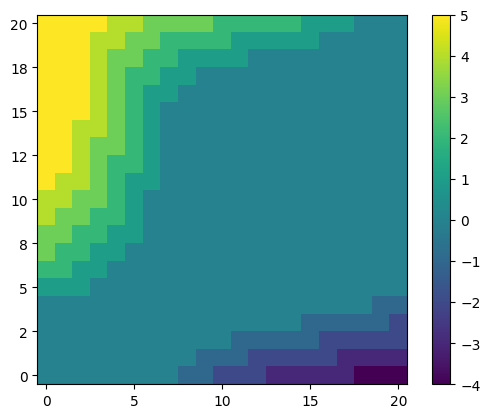

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.imshow(policy[:, :], origin="lower")
plt.colorbar()
ax = plt.gca()
# Rewrite the y labels
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f"))

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f"))
plt.show()

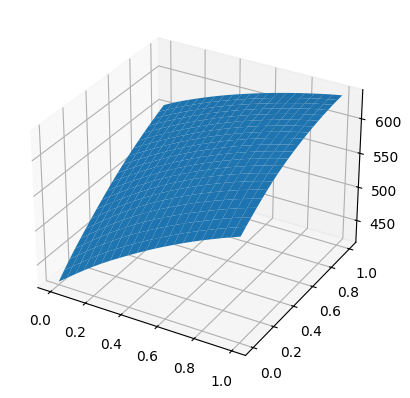

In [14]:
# Create a figure
fig = plt.figure()

# Specify that we are going to create a 3D plot
ax = fig.add_subplot(111, projection="3d")

x = np.linspace(0, 1, 21)
y = np.linspace(0, 1, 21)
X, Y = np.meshgrid(x, y)

# Plot the surface
ax.plot_surface(X, Y, V)

# Show the plot
plt.show()

# Part 4: Nonlinearities

In [25]:
# Now we add two more conditions (from Ex. 4.7)
# 1. 1 car from loc1 to loc2 is free per day (ie. if n_moved >= 1, r_moved += 2)
# 2. Each car over 10 after moving incurs a cost of $4.

# Note: these changes all occur in the car moving phase and are deterministic - we bundle them into the char move definition and then rerun the above funcs

In [62]:
def move_cars_pt2(
    s: tuple[int, int], a: int, verbose=False
) -> tuple[int, tuple[int, int]]:
    n1, n2 = s
    if verbose:
        print(f"Starting State: {s}")

    # first we move the cars
    n_moved = A[a]
    if verbose:
        print(f"Moving {n_moved} car(s)")

    # $2 cost per car moved
    r_moving = -abs(n_moved) * 2

    if n_moved >= 1:
        r_moving += 2  # one move from loc 1 to loc 2 is free -> reduces the cost of moving by $2

    # execute the move
    n1 -= n_moved
    n2 += n_moved

    # if either value is negative the model has taken an impossible action:
    # just return to prev state
    if (n1 < 0) or (n2 < 0):
        if verbose:
            print(f"Invalid action {n_moved=} from state {s=}")
        return 0, s, False

    # at most we can have 20 cars at a location
    n1 = min(n1, 20)
    n2 = min(n2, 20)

    if verbose:
        print(f"Post-move: {n1=} {n2=}")

    # there is an additional penalty for all cars over 10
    # n1_penalty = max(0, n1 - 10)
    # n2_penalty = max(0, n2 - 10)
    # penalty = 4 * (n1_penalty + n2_penalty)
    # r_moving -= penalty
    # if verbose:
    #     print(f"Applying a penalty of ${penalty}, due to state {n1=} {n2=}")

    # There is a penalty of $4 if n1 or n2 is higher than 10
    if n1 > 10 or n2 > 10:
        r_moving -= 4

    new_state = (n1, n2)
    return r_moving, new_state, True

In [63]:
V, A, pi = initialise()

In [64]:
# now we redo policy eval, but using the new move_cars func
def policy_evaluation_pt2(V, pi) -> np.ndarray:
    V = np.copy(V)
    theta = 0.1
    delta = -1
    i = 1
    while True:
        print(f"Policy Evaluation Iteration: {i}: {delta=:.2f}")
        delta = 0
        for s in np.ndindex(V.shape):
            v = V[s]
            # evaluate reward from s'
            a = pi[s]
            r_move, s_prime, valid_action = move_cars_pt2(s, a)
            if not valid_action:
                continue
            state_value = new_state_value(s_prime, V, r_move)
            V[s] = state_value
            delta = max(delta, np.abs(v - state_value))
        i += 1
        if delta < theta:
            break
    return V


# policy improvement
gamma = 0.9
i = 1
while True:
    print(f"Policy Improvement Iteration: {i}")
    policy_stable = True
    for s in np.ndindex(V.shape):
        a_old = pi[s]
        # do the value iteration
        # iterate over all the actions
        G_max = -10
        a_new = -1
        for a in np.arange(0, 11):
            r_move, s_prime, valid_action = move_cars_pt2(s, a)
            if not valid_action:
                continue
            G = new_state_value(s_prime, V, r_move)
            if G > G_max:
                G_max = G
                a_new = a
        pi[s] = a_new
        if a_new != a_old:
            policy_stable = False

    i += 1
    if not policy_stable:
        V = policy_evaluation_pt2(V, pi)
    else:
        break

Policy Improvement Iteration: 1
Policy Evaluation Iteration: 1: delta=-1.00
Policy Evaluation Iteration: 2: delta=207.50
Policy Evaluation Iteration: 3: delta=139.65
Policy Evaluation Iteration: 4: delta=96.07
Policy Evaluation Iteration: 5: delta=71.52
Policy Evaluation Iteration: 6: delta=55.80
Policy Evaluation Iteration: 7: delta=42.78
Policy Evaluation Iteration: 8: delta=32.99
Policy Evaluation Iteration: 9: delta=26.30
Policy Evaluation Iteration: 10: delta=21.56
Policy Evaluation Iteration: 11: delta=17.66
Policy Evaluation Iteration: 12: delta=14.45
Policy Evaluation Iteration: 13: delta=11.81
Policy Evaluation Iteration: 14: delta=9.66
Policy Evaluation Iteration: 15: delta=7.89
Policy Evaluation Iteration: 16: delta=6.45
Policy Evaluation Iteration: 17: delta=5.27
Policy Evaluation Iteration: 18: delta=4.31
Policy Evaluation Iteration: 19: delta=3.52
Policy Evaluation Iteration: 20: delta=2.88
Policy Evaluation Iteration: 21: delta=2.35
Policy Evaluation Iteration: 22: delta

In [68]:
policy = pi - 5
with open("policy_pt2.pkl", "wb") as f:
    pickle.dump(policy, f)

with open("values_pt2.pkl", "wb") as f:
    pickle.dump(V, f)

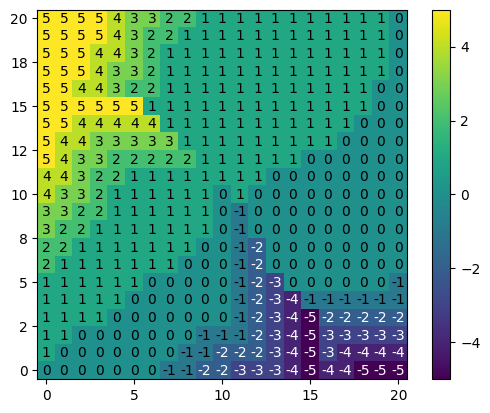

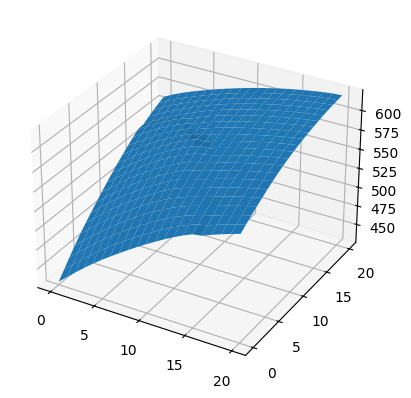

In [75]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plot_policy(policy)
plot_value_function(V)

In [70]:
move_cars_pt2((20, 20), 0, True)

Starting State: (20, 20)
Moving -5 car(s)
Post-move: n1=20 n2=15


(-14, (20, 15), True)

In [53]:
policy[20, 20]

-5

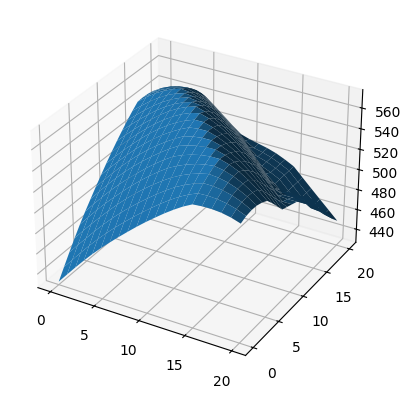